In [1]:
import gmsh
import numpy as np

gmsh.initialize()
gmsh.model.add("torus")

# Parameters for the torus
R = 1.0   # Major radius
r = 0.3   # Minor radius

torus = gmsh.model.occ.addTorus(0, 0, 0, R, r)
gmsh.model.occ.synchronize()

volumes = gmsh.model.getEntities(dim=3)
gmsh.model.addPhysicalGroup(3, [v[1] for v in volumes], tag=1)
gmsh.model.setPhysicalName(3, 1, "domain")

# (Optional) Also add physical surfaces for boundary tags if needed
surfaces = gmsh.model.getEntities(dim=2)
gmsh.model.addPhysicalGroup(2, [s[1] for s in surfaces], tag=1)
gmsh.model.setPhysicalName(2, 1, "surface")

# Mesh settings
gmsh.model.mesh.setSize(gmsh.model.getEntities(0), 0.15)

gmsh.model.mesh.generate(3)
gmsh.write("torus.msh")
gmsh.finalize()




Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 60%] Meshing curve 2 (Circle)
Info    : Done meshing 1D (Wall 0.000105666s, CPU 0.000157s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Torus, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0211437s, CPU 0.020883s)
Info    : Meshing 3D...
Info    : 3D Meshing 1 volume with 1 connected component
Info    : Tetrahedrizing 658 nodes...
Info    : Done tetrahedrizing 666 nodes (Wall 0.00487142s, CPU 0.00483s)
Info    : Reconstructing mesh...
Info    :  - Creating surface mesh
Info    :  - Identifying boundary edges
Info    :  - Recovering boundary
Info    : Done reconstructing mesh (Wall 0.0129439s, CPU 0.012543s)
Info    : Found volume 1
Info    : It. 0 - 0 nodes created - worst tet radius 2.16664 (nodes removed 0 0)
Info    : 3D refinement terminated (839 nodes total):
Info    :  - 0 Delaunay cavities modified for star shapeness
Info    :  - 0 nodes could not be inserted
Info    :  - 2883 tetrahedra 

In [2]:
from mpi4py import MPI
from dolfinx.io import gmshio
from dolfinx import fem
from ufl import TrialFunction, TestFunction, curl, inner, cross, dx, ds, FacetNormal
from petsc4py import PETSc
import numpy as np

# 1. Read torus mesh from Gmsh 
domain, cell_tags, facet_tags = gmshio.read_from_msh("torus.msh", MPI.COMM_WORLD, gdim=3)

# 2. Define function space
V = fem.functionspace(domain, ("N1curl",1, (domain.topology.dim,)))
u = TrialFunction(V)
v = TestFunction(V)
n = FacetNormal(domain)
mu = 1

a = inner(u, curl(v)) * dx + inner(n, cross(u, v)) * ds - mu * inner(u, v) * dx
f = fem.Constant(domain, PETSc.ScalarType((1,0,0)))
L = inner(f, v) * dx

from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(a, L, bcs=[], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# Interpolate for visualization (Lagrange)
V_cg = fem.functionspace(domain, ("Lagrange", 1, (domain.topology.dim,)))
uh_cg = fem.Function(V_cg)
uh_cg.interpolate(uh)

from dolfinx.io import XDMFFile
with XDMFFile(MPI.COMM_WORLD, "torus_solution.xdmf", "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh_cg)




Info    : Reading 'torus.msh'...
Info    : 5 entities
Info    : 839 nodes
Info    : 4144 elements
Info    : Done reading 'torus.msh'


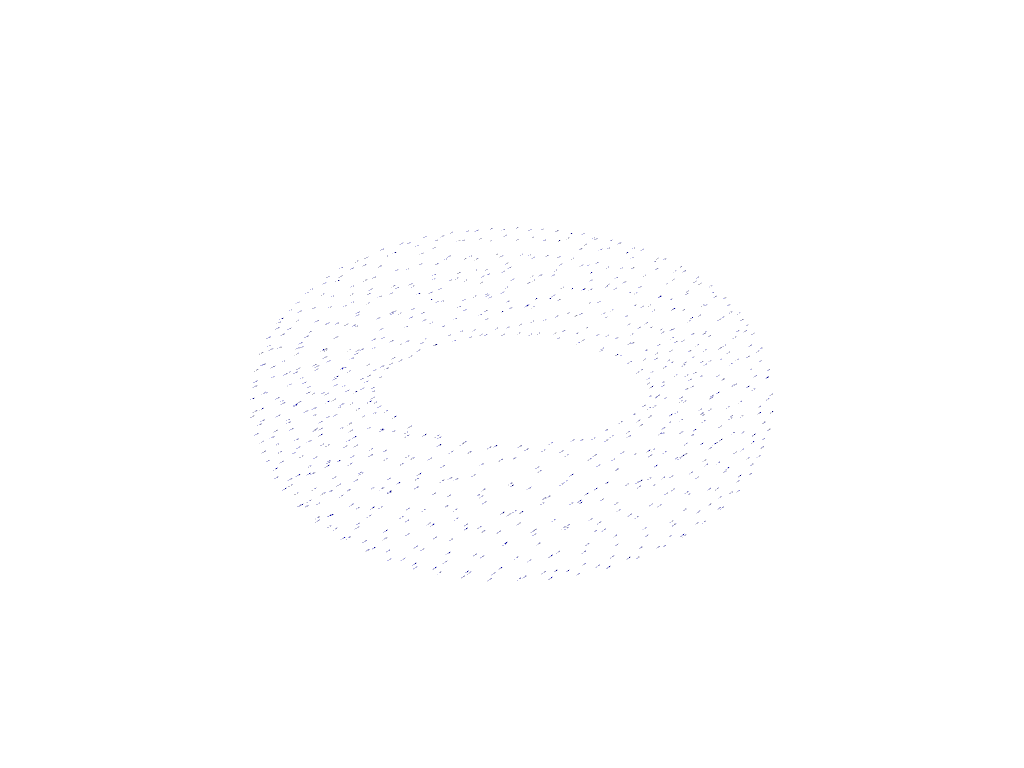

In [3]:
import pyvista as pv

points = domain.geometry.x
vectors = uh_cg.x.array.reshape(-1, 3)

cloud = pv.PolyData(points)
cloud["B"] = vectors

# Extract surface for less clutter and clearer visualization
surf = cloud.extract_surface()

# Use glyphs (arrows) for the vector field
glyphs = surf.glyph(orient="B", factor=0.03)  # Adjust factor for arrow length

p = pv.Plotter()
p.add_mesh(glyphs, color="b")
p.show()
